In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

atlas = pd.read_csv('data/usds_atlas_cleaned.csv')
mmg = pd.read_csv('data/t19_23_cleaned.csv')

Do counties with large numbers of food deserts also have high numbers of food insecurity rates?

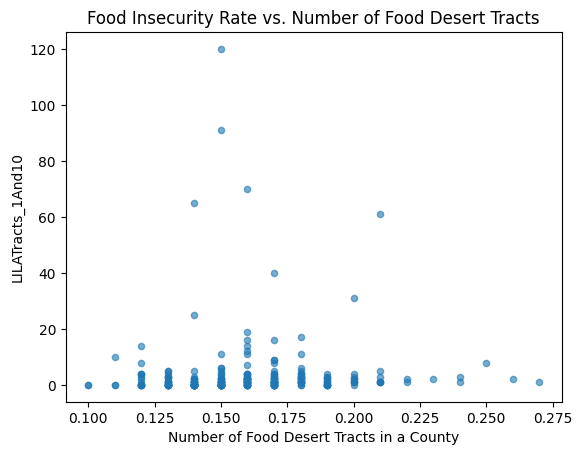

In [2]:
#food deserts per county 
fd_per_county = atlas.groupby('County')['LILATracts_1And10'].sum()

#average food insecurity rate across 2019-23 per county 
mmg.rename(columns={'County, State': 'County'}, inplace=True)
avg_FI = mmg.groupby('County')['Overall Food Insecurity Rate'].mean().round(2)

merged = pd.merge(fd_per_county, avg_FI, how='inner', on='County')

merged.plot(kind='scatter', y='LILATracts_1And10', x='Overall Food Insecurity Rate', alpha=0.6)
plt.xlabel('Number of Food Desert Tracts in a County')
plt.title('Food Insecurity Rate vs. Number of Food Desert Tracts')
plt.show()


In [3]:
from scipy.stats import pearsonr

pearson_corr, pearson_p = pearsonr(merged['LILATracts_1And10'], merged['Overall Food Insecurity Rate'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
print('There was no significant correlation or relationship between these variables.')

Pearson correlation: 0.0278, p-value: 6.5970e-01
There was no significant correlation or relationship between these variables.


SNAP coverage gap. People who qualify - people who actually get SNAP beneifts (2019)

In [4]:
mmg['# ppl that qualify for SNAP'] = mmg['% FI ≤ SNAP Threshold']*mmg['# of Food Insecure Persons Overall']
mmg['# ppl that qualify for SNAP'] = mmg['# ppl that qualify for SNAP'].round(2)
mmg = mmg[mmg['Year'] == 2019].copy() #filter for just 2019 year SNAP data

atlas_snap = atlas.groupby('County')['TractSNAP'].sum()

snap_gap_merged = pd.merge(mmg, atlas_snap, on='County')
snap_gap_merged['SNAP Gap'] = round((snap_gap_merged['# ppl that qualify for SNAP'] - snap_gap_merged['TractSNAP']),2)
snap_gap_merged.sort_values(by='SNAP Gap', inplace=True, ascending=False)
final_snap_gap = snap_gap_merged[['County', 'SNAP Gap']]

for i, row in enumerate(final_snap_gap.head(10).itertuples(),1):
    print(f'{i}. {row.County}: {round(row._2):,}')

1. Harris: 249,374
2. Dallas: 152,172
3. Bexar: 111,606
4. Tarrant: 81,214
5. Hidalgo: 74,054
6. El Paso: 49,804
7. Travis: 48,244
8. Cameron: 38,580
9. Collin: 27,996
10. Denton: 22,276


Final: Make your own food insecurity score that can be used to rank counties
- What counties come out as the most in need of help, and which ones are the best off? 

In [5]:
'''
1. food insecurity rate
2. SNAP Gap
3. % FI ≤ SNAP Threshold
4. Number of food desert tracts
5. Cost per Meal 
'''

final_atlas = atlas.groupby('County')[['LILATracts_1And10']].sum().reset_index()

final_atlas = atlas.groupby('County')['LILATracts_1And10'].sum()
final_mmg = mmg[['County','Overall Food Insecurity Rate', '% FI ≤ SNAP Threshold', 'Cost Per Meal']]

merged1 = pd.merge(final_atlas, final_snap_gap, on='County')
final_merged = pd.merge(merged1, final_mmg, on='County')


#normalization of columns 
def normalize(series):
    series_norm = (series - series.min())/(series.max() - series.min())
    return series_norm

final_merged.set_index('County', inplace=True)
final_merged.to_csv('final_merged_notnormalized.csv')
final_merged = final_merged.apply(normalize)
final_merged['Final Score'] = final_merged.sum(axis=1).round(4)
final_merged.sort_values(by='Final Score', inplace=True, ascending=False)

final_score_list = final_merged.head(10).index.tolist()

print('According to our generated food insecurity score, these are the counties with the worst scores')
print('and that are in the most dire need for help:')

for i, val in enumerate(final_score_list, 1):
    score = final_merged.loc[val, 'Final Score']
    print(f"{i}. {val}: {score:.4f}")

According to our generated food insecurity score, these are the counties with the worst scores
and that are in the most dire need for help:
1. Harris: 3.4565
2. Dallas: 2.9020
3. Presidio: 2.6639
4. Hidalgo: 2.5217
5. Bexar: 2.4040
6. Cottle: 2.2411
7. El Paso: 2.2356
8. Starr: 2.2060
9. Tarrant: 2.1390
10. Hall: 2.1277


In [6]:
final_merged.to_csv('final_merged.csv')